In [ ]:
# Shift+Enter to run a cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# This line makes plots show up nicely
%matplotlib inline

In [ ]:
# Load the life expectancy data
life_df = pd.read_csv('data/life_expectancy.csv', skiprows=4)

# Show first 5 rows
life_df.head()

In [ ]:
# Dimensions of DataFrame
print("Life Expectancy DataFrame Shape:", life_df.shape)

# Get summary of DataFrame
life_df.info

In [ ]:
# Health Expenditure
health_exp_df = pd.read_csv('data/health_expenditure.csv', skiprows=4)
health_exp_df.head()

print("Health Expenditure DataFrame Shape:", health_exp_df.shape)
health_exp_df.info

In [ ]:
# Physicians
physicians_df = pd.read_csv('data/physicians.csv', skiprows=4)
physicians_df.head()

print("Physicians DataFrame Shape:", physicians_df.shape)
physicians_df.info

In [ ]:
# Identify which columns are years
year_columns = [col for col in life_df.columns if col.isdigit() and len(col) == 4]

print("First 10 year columns:", year_columns[:10])
print("Number of year columns found:", len(year_columns))

In [ ]:
# Select the columns: Country names, codes, and all the year columns
life_long = life_df.melt(
    id_vars=['Country Name', 'Country Code'], # These stay as columns
    value_vars=year_columns,           # These are all the year columns
    var_name='Year',                          # New year column name
    value_name='Life_Exp'                     # New value column name
)

print("Life Expectancy (Long Format) Shape:", life_long.shape)
life_long.head()

In [ ]:
# Melt the health expenditure data
health_exp_long = health_exp_df.melt(
    id_vars=['Country Name', 'Country Code'],
    value_vars=year_columns,
    var_name='Year',
    value_name='Health_Exp_PC' # PC for Per Capita
)
print("Health Expenditure (Long Format) Shape:", health_exp_long.shape)

# Melt the physicians data
physicians_long = physicians_df.melt(
    id_vars=['Country Name', 'Country Code'],
    value_vars=year_columns,
    var_name='Year',
    value_name='Physicians'
)
print("Physicians (Long Format) Shape:", physicians_long.shape)

In [ ]:
# Merge Life Expectancy and Health Expenditure
merged_df = pd.merge(life_long, health_exp_long, on=['Country Name', 'Country Code', 'Year'])

# Merge Physicians data
master_df = pd.merge(merged_df, physicians_long, on=['Country Name', 'Country Code', 'Year'])

print("Master DataFrame Shape:", master_df.shape)
master_df.head(10)

In [ ]:
# Check the number of missing values in each column

master_df.isnull().sum()

In [ ]:
master_df['Year'] = master_df['Year'].astype(int)

# Check the new master DataFrame
print("Master DataFrame Shape:", master_df.shape)
print("Year column data type:", master_df['Year'].dtype)
master_df.head()

In [ ]:
# Filter for years from 2000 onwards
df_recent = master_df[master_df['Year'] >= 2000]
print("Shape of recent data:", df_recent.shape)

In [ ]:
# List of countries to compare
countries_to_plot = ['United Kingdom', 'United States', 'China', 'India', 'Germany', 'Brazil', 'South Africa']
plot_df = df_recent[df_recent['Country Name'].isin(countries_to_plot)]

# Create the plot
plt.figure(figsize=(14, 8)) # Makes the plot bigger
sns.lineplot(data=plot_df, x='Year', y='Life_Exp', hue='Country Name', errorbar=None)
plt.title('Life Expectancy Trends (2000-Present)')
plt.ylabel('Life Expectancy (years)')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Puts legend outside the plot
plt.tight_layout() # Adjusts layout to fit everything
plt.show()

In [ ]:
# Filter for a specific year
df_2018 = df_recent[df_recent['Year'] == 2018]

# Create a scatter plot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=df_2018, x='Health_Exp_PC', y='Life_Exp', hue='Country Name', legend=False, s=50)

# Get current axes for coordinate transformation
ax = plt.gca()

# Add country labels with better positioning for log scale
for line in range(0, df_2018.shape[0]):
    country = df_2018.iloc[line]['Country Name']
    # Only label specific countries to avoid clutter
    if country in ['United States', 'China', 'India', 'Luxembourg', 'Japan', 'Cuba', 'Sierra Leone', 'United Kingdom']:
        x_val = df_2018.iloc[line]['Health_Exp_PC']
        y_val = df_2018.iloc[line]['Life_Exp']
        
        # For log scale, we'll use a small multiplicative offset instead of additive
        # This will work better across the entire range of values
        text = ax.text(x_val * 1.05,
                       y_val, 
                       country, 
                       fontsize=9,
                       ha='left',   # Horizontal alignment to left
                       va='center') # Vertical alignment to center

plt.title('Health Expenditure vs. Life Expectancy (2018)')
plt.xlabel('Health Expenditure per Capita (US $)')
plt.ylabel('Life Expectancy (years)')
plt.xscale('log')
plt.show()

In [42]:
# Find which years have at least some complete data for all three metrics
complete_data_by_year = []
for year in sorted(df_recent['Year'].unique(), reverse=True):
    year_data = df_recent[df_recent['Year'] == year]
    complete_count = len(year_data.dropna(subset=['Life_Exp', 'Health_Exp_PC', 'Physicians']))
    complete_data_by_year.append((year, complete_count))
    
    if complete_count >= 30:
        most_recent_valid_year = year
        break

print("Complete data by year:")
for year, count in complete_data_by_year:
    print(f"{year}: {count} countries with complete data")
    
print(f"\nUsing year: {most_recent_valid_year}")

# Filter for this year and get complete data
df_recent_year = df_recent[df_recent['Year'] == most_recent_valid_year]
df_clean = df_recent_year.dropna(subset=['Life_Exp', 'Health_Exp_PC', 'Physicians'])

print(f"Number of countries with complete data for {most_recent_valid_year}: {len(df_clean)}")

# Create the interactive scatter plot
fig_scatter = px.scatter(df_clean,
                         x='Health_Exp_PC',
                         y='Life_Exp',
                         size='Physicians',
                         hover_name='Country Name',
                         hover_data=['Country Code', 'Health_Exp_PC', 'Life_Exp', 'Physicians'],
                         title=f'Health Expenditure vs. Life Expectancy ({most_recent_valid_year})',
                         labels={'Health_Exp_PC': 'Health Expenditure per Capita (US $)',
                                 'Life_Exp': 'Life Expectancy (years)',
                                 'Physicians': 'Physicians per 1k'},
                         log_x=True,
                         width=1000,
                         height=600)

# Make the hover tool show more precise numbers
fig_scatter.update_traces(hovertemplate='<b>%{hovertext}</b><br>' +
                                        'Health Expenditure: $%{x:,.0f}<br>' +
                                        'Life Expectancy: %{y:.1f} years<br>' +
                                        'Physicians: %{marker.size:.2f} per 1k' +
                                        '<extra></extra>')

fig_scatter.show()

Complete data by year:
2024: 0 countries with complete data
2023: 0 countries with complete data
2022: 61 countries with complete data

Using year: 2022
Number of countries with complete data for 2022: 61


In [37]:
from scipy import stats

# Calculate Pearson's r for the 2022 data
df_2022_clean = df_clean[['Health_Exp_PC', 'Life_Exp']].dropna() # Ensure we're using the same cleaned dataset

pearson_r, p_value = stats.pearsonr(df_2022_clean['Health_Exp_PC'], df_2022_clean['Life_Exp'])

print(f"Pearson's r (Correlation Coefficient): {pearson_r:.3f}")
print(f"P-value: {p_value:.3g}")

# Interpret the strength
if abs(pearson_r) >= 0.7:
    strength = "strong"
elif abs(pearson_r) >= 0.5:
    strength = "moderate"
elif abs(pearson_r) >= 0.3:
    strength = "weak"
else:
    strength = "very weak, or no"

direction = "positive" if pearson_r > 0 else "negative"

print(f"\nInterpretation: There is a {strength} {direction} linear correlation between health expenditure and life expectancy.")

Pearson's r (Correlation Coefficient): 0.723
P-value: 4.82e-11

Interpretation: There is a strong positive linear correlation between health expenditure and life expectancy.


In [35]:
# Filter for countries with similar health expenditure to the UK (~$5000)
# Let's look at countries spending between $4000 and $6000
peer_group = df_clean[(df_clean['Health_Exp_PC'] >= 4000) & (df_clean['Health_Exp_PC'] <= 6000)]

# Sort this peer group by Physicians per 1k to see the UK's rank
peer_group_sorted = peer_group.sort_values('Physicians', ascending=False)
print(peer_group_sorted[['Country Name', 'Health_Exp_PC', 'Life_Exp', 'Physicians']].to_string())

         Country Name  Health_Exp_PC   Life_Exp  Physicians
16506         Austria    5851.962402  81.295122       5.508
16607          Israel    4223.872559  82.700000       3.713
16672     New Zealand    4804.377930  81.958537       3.574
16573  United Kingdom    5035.617188  81.011220       3.174


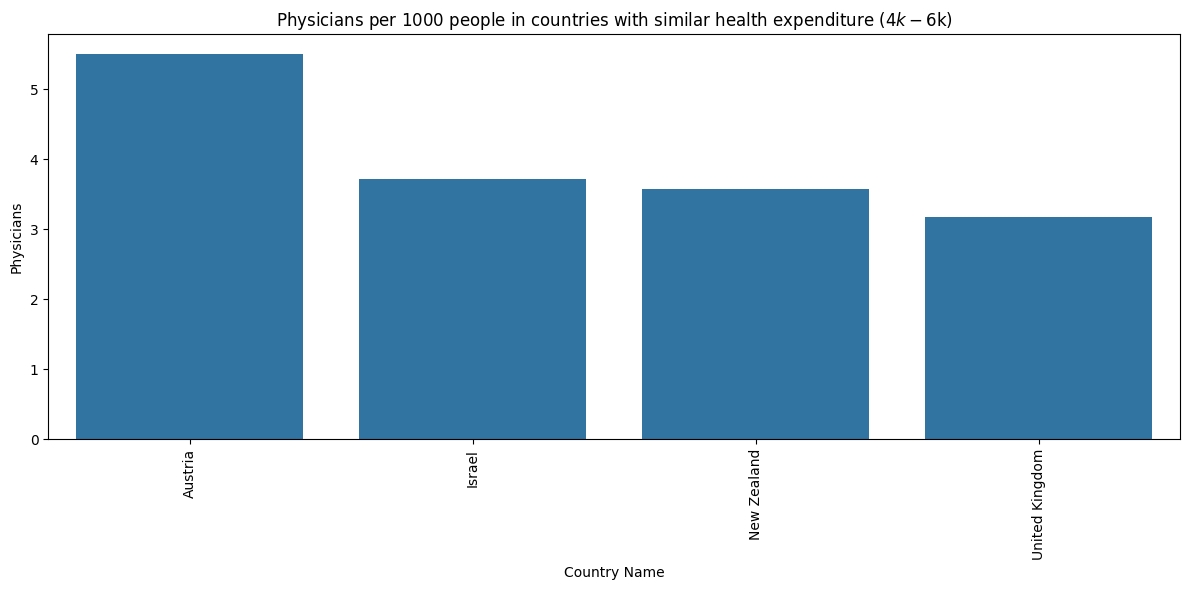

In [36]:
plt.figure(figsize=(12, 6))
sns.barplot(data=peer_group_sorted, x='Country Name', y='Physicians')
plt.xticks(rotation=90) # Rotate country names so they're readable
plt.title('Physicians per 1000 people in countries with similar health expenditure ($4k-$6k)')
plt.tight_layout()
plt.show()

In [39]:
# Create a choropleth map for Life Expectancy in 2022
fig_map = px.choropleth(df_clean,
                    locations="Country Code",
                    color="Life_Exp",            # This column determines the color
                    hover_name="Country Name",   # Shows on hover
                    hover_data=["Health_Exp_PC", "Physicians"], # Additional data on hover
                    color_continuous_scale=px.colors.sequential.Plasma, # Color scale
                    title='Global Life Expectancy (2022)',
                    labels={'Life_Exp': 'Life Expectancy (years)'}, # Label for the color scale
                    width=1000,
                    height=600)

# Improve the hover template to show precise values
fig_map.update_traces(hovertemplate='<b>%{hovertext}</b><br>' +
                                    'Life Expectancy: %{z:.1f} years<br>' +
                                    'Health Expenditure: $%{customdata[0]:,.0f}<br>' +
                                    'Physicians: %{customdata[1]:.2f} per 1k' +
                                    '<extra></extra>')

fig_map.show()

In [40]:
# Export the interactive plots to HTML files
fig_map.write_html("docs/map_plot.html")
fig_scatter.write_html("docs/scatter_plot.html")

print("Interactive HTML files have been saved to the 'docs' folder!")

Interactive HTML files have been saved to the 'docs' folder!
